### 1. Initialize project environemnt and create an agent

In [1]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name='Reacher_multi.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


In [3]:
import torch
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

### 2. Train the agent and store trained model weights into checkpoint.pth file.

FYI: Instead of training the agent from sracth to run in project environment, it is possible to load the stored model weights of already trained agent from please skip steps 2 and 3 and jump directly to step 4.

In [4]:
from collections import deque

def ddpg(n_episodes=1000, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)

            states = next_states
            score += rewards
            if np.any(dones):
                break

        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        eval_window_avg_score = np.mean(scores_deque)
        avg_scores.append(eval_window_avg_score)
        total_episodes = min(i_episode, 100)
        print('\rEpisode {} average score: {:.2f}, Average score over last {} episodes: {:.2f}'.format(i_episode, np.mean(score), total_episodes, eval_window_avg_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {} average score: {:.2f}, Average score over last {} episodes: {:.2f}'.format(i_episode, np.mean(score), total_episodes, eval_window_avg_score))
        if np.mean(scores_deque) >= 30:
            print('\nEnvironment solved in {:d} episodes!\t Average score over last {} episodes: {:.2f}'.format(i_episode, total_episodes, eval_window_avg_score))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            break
    return scores, avg_scores

scores, avg_scores = ddpg(n_episodes=400)

Episode 10 average score: 1.47, Average score over last 10 episodes: 0.80
Episode 20 average score: 3.24, Average score over last 20 episodes: 1.70
Episode 30 average score: 5.37, Average score over last 30 episodes: 2.93
Episode 40 average score: 7.45, Average score over last 40 episodes: 3.94
Episode 50 average score: 8.54, Average score over last 50 episodes: 4.83
Episode 60 average score: 11.16, Average score over last 60 episodes: 5.65
Episode 70 average score: 12.02, Average score over last 70 episodes: 6.50
Episode 80 average score: 14.70, Average score over last 80 episodes: 7.40
Episode 90 average score: 15.08, Average score over last 90 episodes: 8.21
Episode 100 average score: 20.57, Average score over last 100 episodes: 9.24
Episode 110 average score: 28.25, Average score over last 100 episodes: 11.44
Episode 120 average score: 29.08, Average score over last 100 episodes: 13.87
Episode 130 average score: 33.36, Average score over last 100 episodes: 16.41
Episode 140 average

### 3. Visualize results of Agents' training

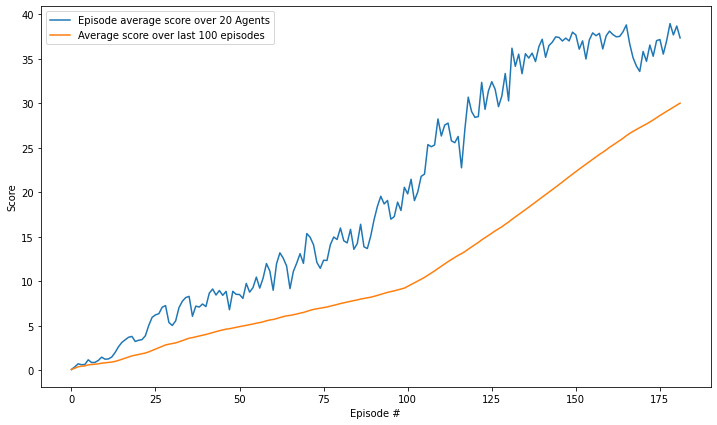

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
## Plot the scores
fig = plt.figure(figsize=(12,7))

ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Episode average score over 20 Agents', 'Average score over last 100 episodes'))

plt.show()

### 4. Run the Agents with pretrained model weights

Once this cell is executed, a Unity window with loaded project environemnt should pop up where the trained Agents can be observed in action, as they operate inside the environment. The 'experience' of the Agents is loaded from stored ''checkpoint_actor.pth' file. These files contains the weights of Agents' neural netowrk model learned during training phase, therefore no need to train the Agents every time from scratch.

In [4]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations  # get the current states
agent.reset()
agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth'))
for t in range(1000):
    actions = agent.act(states, False)            # let the agent select actions (don't add noise)
    env_info = env.step(actions)[brain_name]      # execute the selected actions and save the new information about the environment
    next_states = env_info.vector_observations    # get the resulting states
    dones = env_info.local_done                   # check whether episodes have finished
    states = next_states
    if np.any(dones):
        break 
env.close()